# Feature Selection Example
This notebook shows how to use various feature selection methods using scalecast.

- Download data: https://www.kaggle.com/robervalt/sunspots  
- See here for EDA on this dataset: https://scalecast-examples.readthedocs.io/en/latest/rnn/rnn.html  

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
from scalecast.Forecaster import Forecaster
from scalecast.util import plot_reduction_errors

%load_ext lab_black
pd.options.display.max_rows = None
pd.set_option("display.float_format", lambda x: "%0.4f" % x)

In [2]:
sns.set(rc={"figure.figsize": (12, 8)})

In [3]:
def prepare_fcst(f, test_length=120, fcst_length=120):
    """ adds all variables and sets the test length/forecast length in the object
    
    Args:
        f (Forecaster): the Forecaster object.
        test_length (int or float): the test length as a size or proportion.
        fcst_length (int): the forecast horizon.
        
    Returns:
        (Forecaster) the processed object.
    """
    f.generate_future_dates(fcst_length)
    f.set_test_length(test_length)
    f.set_validation_length(120)
    f.add_seasonal_regressors("month", "quarter", raw=False, sincos=True)
    f.set_validation_metric("mae")
    for i in np.arange(12, 289, 12):  # 12-month cycles from 12 to 288 months
        f.add_cycle(i)
    f.add_ar_terms(120)  # AR 1-120
    f.add_AR_terms((20, 12))  # seasonal AR up to 20 years, spaced one year apart
    f.add_time_trend()
    f.add_seasonal_regressors("year")
    return f


def export_results(f):
    """ returns a dataframe with all model results given a Forecaster object.
    
    Args:
        f (Forecaster): the Forecaster object.
        
    Returns:
        (DataFrame) the dataframe with the pertinent results.
    """
    results = f.export("model_summaries", determine_best_by="TestSetMAE")
    results["N_Xvars"] = results["Xvars"].apply(lambda x: len(x))
    return results[
        [
            "ModelNickname",
            "TestSetMAE",
            "InSampleMAE",
            "TestSetR2",
            "InSampleR2",
            "TestSetLength",
            "N_Xvars",
        ]
    ]

## Load object
- we choose 120 periods (10 years) for all validation and forecasting
- 10 years of observervations to tune model hyperparameters, 10 years to test, and a forecast horizon of 10 years

In [4]:
df = pd.read_csv("Sunspots.csv", index_col=0, names=["Date", "Target"], header=0)
f = Forecaster(y=df["Target"], current_dates=df["Date"])

In [5]:
prepare_fcst(f)

Forecaster(
    DateStartActuals=1749-01-31T00:00:00.000000000
    DateEndActuals=2021-01-31T00:00:00.000000000
    Freq=M
    N_actuals=3265
    ForecastLength=120
    Xvars=['monthsin', 'monthcos', 'quartersin', 'quartercos', 'cycle12sin', 'cycle12cos', 'cycle24sin', 'cycle24cos', 'cycle36sin', 'cycle36cos', 'cycle48sin', 'cycle48cos', 'cycle60sin', 'cycle60cos', 'cycle72sin', 'cycle72cos', 'cycle84sin', 'cycle84cos', 'cycle96sin', 'cycle96cos', 'cycle108sin', 'cycle108cos', 'cycle120sin', 'cycle120cos', 'cycle132sin', 'cycle132cos', 'cycle144sin', 'cycle144cos', 'cycle156sin', 'cycle156cos', 'cycle168sin', 'cycle168cos', 'cycle180sin', 'cycle180cos', 'cycle192sin', 'cycle192cos', 'cycle204sin', 'cycle204cos', 'cycle216sin', 'cycle216cos', 'cycle228sin', 'cycle228cos', 'cycle240sin', 'cycle240cos', 'cycle252sin', 'cycle252cos', 'cycle264sin', 'cycle264cos', 'cycle276sin', 'cycle276cos', 'cycle288sin', 'cycle288cos', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10

In [6]:
print("starting out with {} variables".format(len(f.get_regressor_names())))

starting out with 184 variables


## Reducing with L1 Penalty/Lasso
- L1 regularization reduces out least important variables linearly
- Not computationally expensive
- set `overwrite=False` to not replace variables currently in object

In [7]:
f.reduce_Xvars(overwrite=False)
lasso_reduced_vars = f.reduced_Xvars[:]

In [27]:
print(
    "We started with {} variables and only {} of them have useful effects on predictions according to the lasso model.".format(
        len(f.get_regressor_names()), len(lasso_reduced_vars),
    )
)

We started with 184 variables and only 34 of them have useful effects on predictions according to the lasso model.


## Reducing with Permutation Feature Importance (PFI)
- uses the [ELI5 package](https://github.com/eli5-org/eli5) to score feature importances
- eliminates the least-scoring variable (with some scalecast adjustment to account for collinearity), re-trains the model, and evaluates the new error
- by default, the Xvars that return the best error score (according to any metric you want to monitor) is chosen as the optimal set of variables
- to save computation resources, not every variable combination is tried (unlike other reduction techniques)
- to save computation resources, we can set `dynamic_testing = False` and we can set a mininum number of variables to use (the square root of the total number of observations is chosen in this example)
- we can use any sklearn model to reduce variables using this method and we select MLR, KNN, and GBT in this example

In [9]:
f.reduce_Xvars(
    method="pfi",
    overwrite=False,
    estimator="mlr",
    dynamic_testing=False,
    monitor="ValidationMetricValue",
    keep_at_least="sqrt",
)

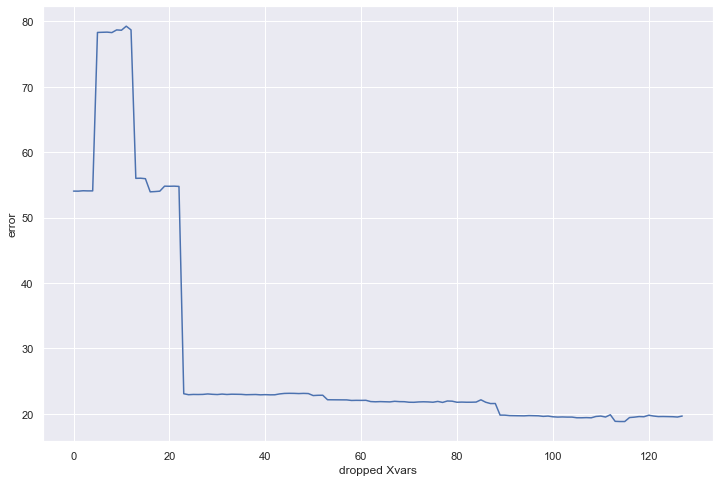

In [10]:
plot_reduction_errors(f)
plt.show()

The above graph shows that the MLR performs best when over 110 variables are reduced, according to the MAE on the validation set. The order the variables were dropped was based on permutation feature importance. Clearly, too many variables had been added initially and reducing them out made a significant difference to the model's performance.

In [11]:
def reduce_and_save_output(f, model, results):
    f.reduce_Xvars(
        method="pfi",
        overwrite=False,
        estimator=model,
        dynamic_testing=False,
        monitor="ValidationMetricValue",
        keep_at_least="sqrt",
    )
    results[model] = [
        f.reduced_Xvars,
        f.pfi_dropped_vars,
        f.pfi_error_values,
        f.reduction_hyperparams,
    ]

In [12]:
results = {"mlr": [f.reduced_Xvars, f.pfi_dropped_vars, f.pfi_error_values]}
for model in ("knn", "gbt"):
    print(f"reducing with {model}")
    reduce_and_save_output(f.deepcopy(), model, results)

reducing with knn
reducing with gbt


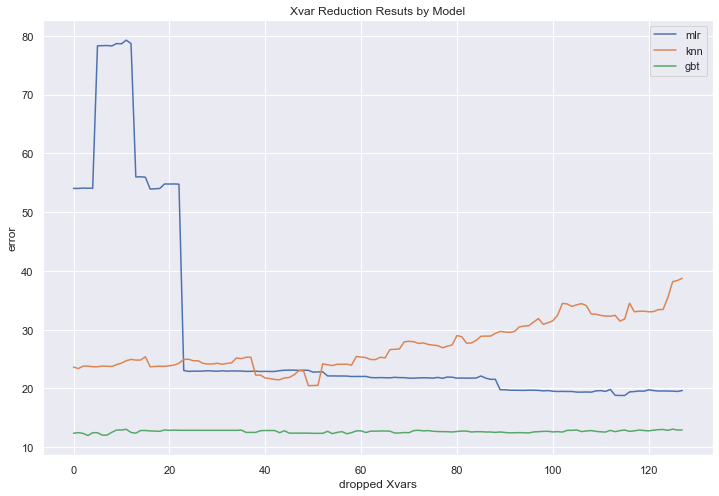

In [13]:
_, ax = plt.subplots()
for k, v in results.items():
    sns.lineplot(
        x=np.arange(0, len(v[1]) + 1, 1), y=v[2], label=k,
    )
plt.xlabel("dropped Xvars")
plt.ylabel("error")
plt.title("Xvar Reduction Resuts by Model")
plt.show()

In [14]:
for k, v in results.items():
    print(f"the {k} model chose {len(v[0])} variables as optimal")

the mlr model chose 70 variables as optimal
the knn model chose 135 variables as optimal
the gbt model chose 181 variables as optimal


Out of the three we tried, the gbt model scored the best on the validation set with 181 variables. We will re-train that model with each of the reduced set of variables and see which reduction performs best on the test set. There is no perfect way to choose a set of variables and it is clear that the GBT model performs only marginally different depending on how many variables are dropped, probably because of how the underlying decision tree model can give lower weight to less-important features natively.

In [15]:
mlr_reduced_vars = results["mlr"][0]
knn_reduced_vars = results["knn"][0]
gbt_reduced_vars = results["gbt"][0]

## Evaluate Model with Reduced Sets of Variables
- use gbt model
- use the optimal hyperparameters already found when reducing the variables with that model

In [16]:
selected_model = "gbt"
hp = results[selected_model][-1]
f.set_estimator(selected_model)
f.manual_forecast(
    **hp, Xvars="all", call_me=selected_model + "_all_vars",
)
f.manual_forecast(
    **hp, Xvars=lasso_reduced_vars, call_me=selected_model + "_l1_reduced_vars",
)
f.manual_forecast(
    **hp, Xvars=mlr_reduced_vars, call_me=selected_model + "_pfi-mlr_reduced_vars",
)
f.manual_forecast(
    **hp, Xvars=knn_reduced_vars, call_me=selected_model + "_pfi-knn_reduced_vars",
)
f.manual_forecast(
    **hp, Xvars=gbt_reduced_vars, call_me=selected_model + "_pfi-gbt_reduced_vars",
)

In [17]:
export_results(f)

,ModelNickname,TestSetMAE,InSampleMAE,TestSetR2,InSampleR2,TestSetLength,N_Xvars
0,gbt_pfi-mlr_reduced_vars,25.7424,15.3578,0.4642,0.9110,120,70
1,gbt_pfi-gbt_reduced_vars,26.7975,14.0273,0.4264,0.9252,120,181
2,gbt_all_vars,26.7975,13.9714,0.4264,0.9260,120,184
3,gbt_l1_reduced_vars,28.2260,14.5770,0.3900,0.9181,120,34
4,gbt_pfi-knn_reduced_vars,31.3929,14.1567,0.2731,0.9231,120,135


Although the gbt model with 181 variables performed best out of all tried models on the validation set, on the test set, the 70 variables selected by MLR led to the best performance. However, all error metrics are fairly close to one another. This illustrates that even if a reduction decision is made with one estimator class, it can still be useful for another model class.

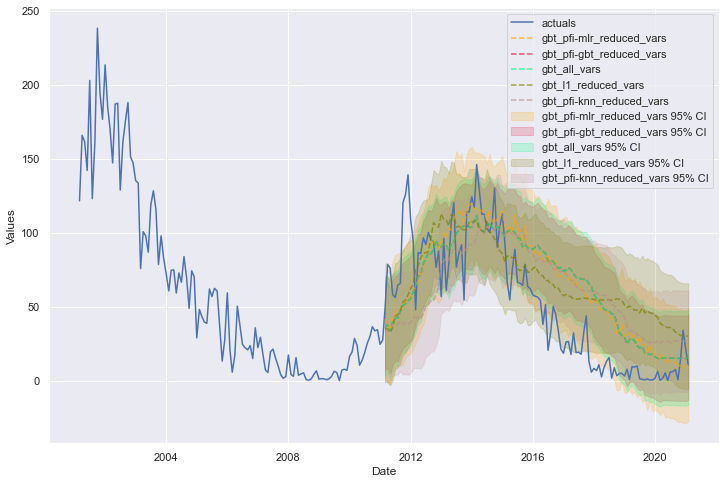

In [19]:
f.plot_test_set(ci=True, order_by="TestSetMAE", include_train=240)
plt.show()

## Backtest best model
- see how well the best-performing gbt model would have performed on the last 25 forecast horizons of 120 months each with the selected hyperparameters and Xvar subset

In [21]:
f.backtest("gbt_pfi-mlr_reduced_vars", n_iter=25)
f.export_backtest_metrics("gbt_pfi-mlr_reduced_vars")

,iter1,iter2,iter3,iter4,iter5,iter6,iter7,iter8,iter9,iter10,...,iter17,iter18,iter19,iter20,iter21,iter22,iter23,iter24,iter25,mean
RMSE,30.4408,29.6837,30.4371,27.2754,27.5272,31.0147,31.2738,33.2380,29.3641,32.2722,...,28.9407,28.8705,29.6741,29.7589,30.5614,32.3217,31.4190,31.3116,31.3910,30.1818
MAE,25.0253,23.8400,25.9076,22.6847,22.5567,25.6809,26.0289,26.9172,24.6017,28.0562,...,23.7808,23.9411,23.7795,24.6771,25.7430,28.0259,26.2390,26.7033,26.8517,25.0676
R2,0.4778,0.5008,0.4748,0.5782,0.5681,0.4453,0.4319,0.3538,0.4930,0.3838,...,0.4832,0.4841,0.4552,0.4507,0.4191,0.3525,0.3906,0.3975,0.3943,0.4538
MAPE,4.1742,3.1796,4.2850,3.1341,3.4508,3.8355,3.1998,3.1345,3.7861,5.3268,...,2.2056,2.3133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.2060


This model performed well on average across the previous 25 forecast horizons for which we have actual data to compare.

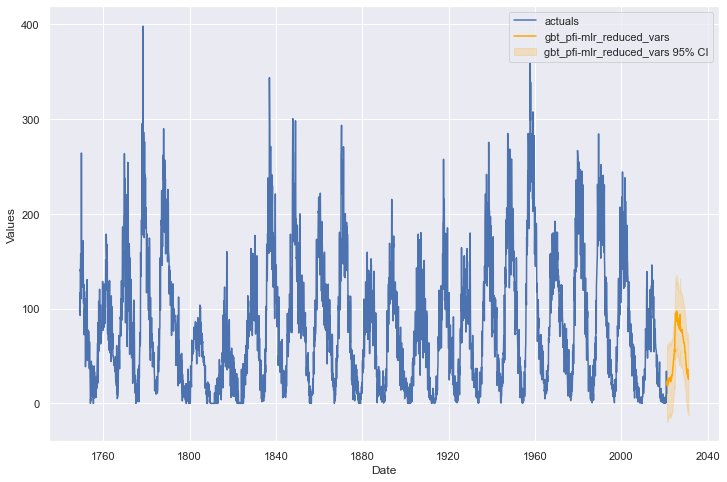

In [24]:
f.plot(models="gbt_pfi-mlr_reduced_vars", ci=True)
plt.show()

## See how often each var was dropped

In [23]:
all_xvars = f.get_regressor_names()
final_dropped = pd.DataFrame({"Var": all_xvars})
for i, v in f.export("model_summaries").iterrows():
    model = v["ModelNickname"]
    Xvars = v["Xvars"]
    dropped_vars = [x for x in f.get_regressor_names() if x not in Xvars]
    if not dropped_vars:
        continue
    tmp_dropped = pd.DataFrame(
        {"Var": dropped_vars, f"dropped in {model}": [1] * len(dropped_vars)}
    )
    final_dropped = final_dropped.merge(tmp_dropped, on="Var", how="left").fillna(0)
final_dropped["total times dropped"] = final_dropped.iloc[:, 1:].sum(axis=1)
final_dropped = final_dropped.loc[final_dropped["total times dropped"] > 0]
final_dropped = final_dropped.sort_values("total times dropped", ascending=False)
final_dropped = final_dropped.reset_index(drop=True)
final_dropped.iloc[:, 1:] = final_dropped.iloc[:, 1:].astype(int)
final_dropped

,Var,dropped in gbt_pfi-mlr_reduced_vars,dropped in gbt_pfi-gbt_reduced_vars,dropped in gbt_l1_reduced_vars,dropped in gbt_pfi-knn_reduced_vars,total times dropped
0,AR83,1,0,1,1,3
1,AR115,1,0,1,1,3
2,AR88,1,0,1,1,3
3,AR22,1,0,1,1,3
4,AR54,1,0,1,1,3
5,AR53,1,0,1,1,3
6,AR99,1,0,1,1,3
7,AR14,1,0,1,1,3
8,AR66,1,0,1,1,3
9,AR103,1,0,1,1,3
